# Iris MLP - multi-task

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
from physics_mi.eval import plot_loss
from torch import nn
from tqdm.notebook import tqdm

In [3]:
class config:
    EPOCHS = 200
    LR = 1e-1

    N_SAMPLES = 50
    BOTTLE_DIM = 4

## Data

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset from sklearn
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_test, dtype=torch.int64)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([120, 4]),
 torch.Size([120]),
 torch.Size([30, 4]),
 torch.Size([30]))

Now to create the stacked datasets:

In [5]:
from torch.utils.data import Dataset, DataLoader


class MultiIris(Dataset):
    def __init__(self, X, y):
        shuffled_indices = torch.randperm(len(X))
        self.X = torch.cat((X, X[shuffled_indices]), dim=1)
        self.y = torch.stack((y, y[shuffled_indices])).T

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
train_ds = MultiIris(X_train, y_train)
valid_ds = MultiIris(X_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([120, 8]), torch.Size([120, 2]))

## Model

In [7]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # cba messing with the dataset that's already neatly packaged
        return self.layers(x)

## Loss function

In [8]:
class MultiIrisLoss(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        return self.loss(y_pred[:, :3], y_true[:, 0]) + self.loss(y_pred[:, 3:], y_true[:, 1])

## Training

In [9]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

model = Net(input_dim=8, hidden_dim=64, output_dim=2 * y_train.unique().shape[0])
optimiser = Adam(model.parameters(), lr=config.LR, weight_decay=1e-2)
loss_func = MultiIrisLoss()
total_steps = len(X_train) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=config.LR, total_steps=total_steps)

Xb_valid, yb_valid = next(iter(valid_dl))

log = []

for epoch in tqdm(range(config.EPOCHS)):
    # Reinitialise the train set to shuffle the combinations
    train_ds = MultiIris(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True)
    xb, yb = next(iter(train_dl))

    log_sample = {}

    model.train()
    y_hat = model(xb)
    loss = loss_func(y_hat, yb)
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        y_hat = model(Xb_valid)
        valid_loss = loss_func(y_hat, yb_valid)

    log_sample["valid_loss"] = float(valid_loss)
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

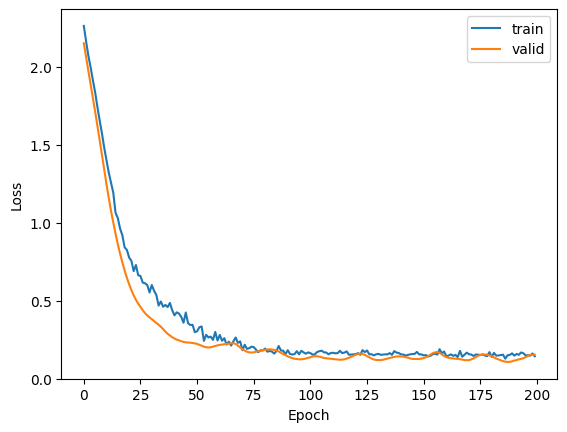

In [10]:
plot_loss(log["train_loss"], log["valid_loss"])

## Results

In [11]:
def get_preds(model, X_valid, y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = y_valid.numpy()

    return y_preds, y_targs

In [13]:
y_preds, y_targs = get_preds(model, Xb_valid, yb_valid)
y_preds_A, y_preds_B = y_preds[:, :3], y_preds[:, 3:]
y_targs_A, y_targs_B = y_targs[:, 0], y_targs[:, 1]
y_preds_A = np.argmax(y_preds_A, axis=1)
y_preds_B = np.argmax(y_preds_B, axis=1)

print(f"Accuracy A: {(y_preds_A == y_targs_A).mean()}")
print(f"Accuracy B: {(y_preds_B == y_targs_B).mean()}")

Accuracy A: 0.9333333333333333
Accuracy B: 0.9666666666666667


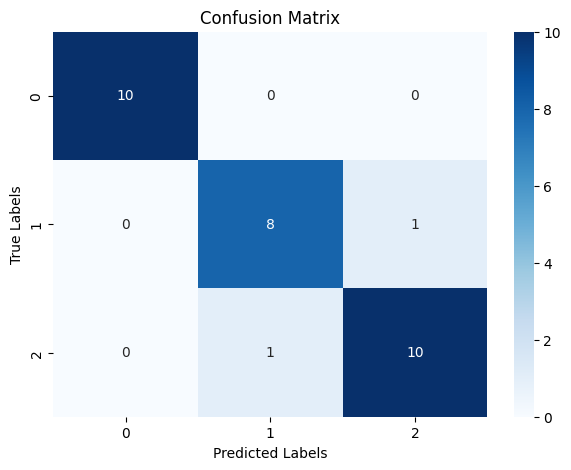

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_targs_A, y_preds_A)

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

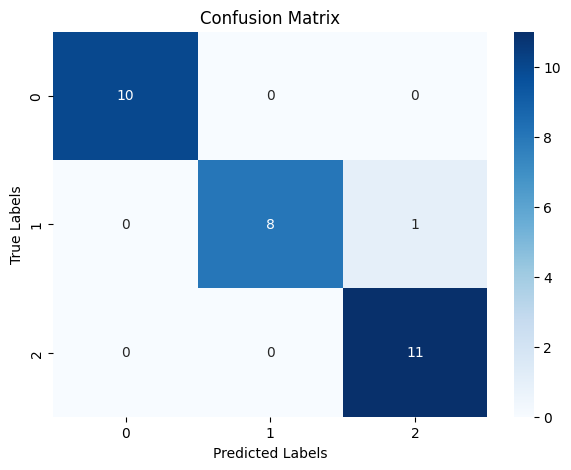

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_targs_B, y_preds_B)

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Task independence

I'm keen to produce some plots like I did in `007-comp-graph/005-soft-mixing`.

In [16]:
from physics_mi.analysis import capture_intermediate_outputs
from physics_mi.graph import generate_graph
from physics_mi.analysis import plot_similarity_matrix, get_sims

In [19]:
valid_ios = capture_intermediate_outputs(model, Xb_valid)
valid_ios["input"] = Xb_valid

In [20]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet(input_dim=8, hidden_dim=64, output_dim=2 * y_train.unique().shape[0])
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [21]:
ios = valid_ios
layer_keys = [
    "input",
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

In [22]:
ndf, edf = generate_graph(ios, layer_keys, scaffold_model)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

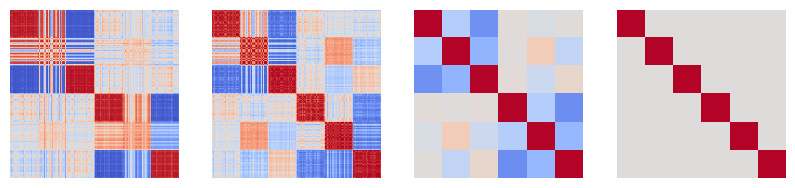

In [23]:
fig, axes = plt.subplots(1, len(layer_keys), figsize=(10, 10))

for ax, key in zip(axes, layer_keys):
    sims = get_sims(ndf, key)
    plot_similarity_matrix(sims, ax=ax, axis=False, colorbar=False)

Our two independent Iris tasks looking pretty neat.

In [24]:
# torch.save(model.state_dict(), "models/iris-mlp.pth")

## Embedding network

Just going to look at this single hidden layer. I think there should be three target components for each independent task and I'd _hope_ to see similar functional embeddings between them.

This node dataframe contains all the nodes across two different layers.

In [25]:
node_df = ndf.loc[ndf["layer"].isin(["layers.1.act", "layers.0.act"])]
node_df

,layer,comp,norm
node,,,
6,layers.1.act,"[tensor(0.0111), tensor(-0.0049), tensor(-0.00...",0.046259
7,layers.1.act,"[tensor(-0.0055), tensor(-0.0060), tensor(-0.0...",0.047242
8,layers.1.act,"[tensor(-0.0088), tensor(0.0112), tensor(0.015...",0.054227
9,layers.1.act,"[tensor(-0.0004), tensor(0.0002), tensor(-0.00...",0.045655
10,layers.1.act,"[tensor(0.0028), tensor(0.0042), tensor(0.0029...",0.045438
...,...,...,...
163,layers.0.act,"[tensor(0.0020), tensor(0.0059), tensor(-0.001...",0.052976
164,layers.0.act,"[tensor(0.0048), tensor(0.0082), tensor(-0.001...",0.065162
165,layers.0.act,"[tensor(0.0053), tensor(0.0080), tensor(-0.001...",0.065709


This edge dataframe contains the connectivity information between the components across this layer.

In [26]:
edge_df = edf.loc[edf["target"].isin(node_df.loc[node_df.layer == "layers.1.act"].index)]
edge_df

,source,target,weight
6,12,6,0.046147
7,13,6,0.047491
8,14,6,0.035528
9,15,6,0.044689
10,16,6,0.046281
...,...,...,...
157,163,11,0.052976
158,164,11,0.065162
159,165,11,0.065709
160,166,11,0.065246


I think this is enough info to get going with the complicated task of arranging the data to train our embedder model 😵‍💫

We'll essentially need to:
- load up our scaffold model and then slice it to this layer of interest (`layers.0.act` $\rightarrow$ `layers.1.act`)
- Then for each training sample we'd pick one of the six components in `layers.1.act`
- pick $n$ training examples to sample the gradient field
- forward pass
- backward pass
- extract gradients
- mask gradients

Then we can use these for our cloze task to train the embedder model.

There are only 6 computational units in this case so I wonder if there'll be enough diversity to train the model well. Then again, we can sample the gradient field differently each time so maybe that would balance out. Whereas before we were only sparse sampling the computational unit space and a dense sampling the gradient field space, here we're dense sampling the computational unit space and sparse sampling the gradient field space. We'll see how that plays out 🤷 

### Data

In [27]:
from physics_mi.utils import unique


class GradientDataset(Dataset):
    def __init__(
        self,
        model: Net,
        scaffold_model: ScaffoldNet,
        node_df: pd.DataFrame,
        X: torch.Tensor,
        y: torch.Tensor,
        mask: bool = True,
        n_samples: int = 50,
    ) -> None:
        self.mask = mask
        self.ndf = node_df
        self.comps = self.prep_target_comps()
        self.comps.requires_grad = False
        self.scaffold_model = scaffold_model  # already trained
        self.scaffold_model.eval()
        for param in self.scaffold_model.parameters():
            param.requires_grad = False
        self.model = model
        self.model.eval()
        self.n_samples = n_samples
        self.X = X
        self.y = y

    def prep_target_comps(self):
        comps = torch.stack([t for t in self.ndf.loc[self.ndf.layer == "layers.1.act", "comp"].values])
        comps = comps / comps.norm(dim=1)[:, None]  # not sure if I should really do this? 🤷
        return comps

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, i):
        # Get the input to the layer
        iris_dset = MultiIris(self.X, self.y)
        iris_dl = DataLoader(iris_dset, batch_size=len(iris_dset), shuffle=True)
        xb, _ = next(iter(iris_dl))
        linput = capture_intermediate_outputs(self.model, xb)["layers.0.act"].clone().detach()
        linput = linput[torch.multinomial(torch.ones(linput.size(0)), self.n_samples)]
        linput.requires_grad = True

        # Get the component activations from the output of the layer
        out = self.scaffold_model(1, linput)
        out = out @ self.comps.T

        # Get the layer input gradients for a randomly selected component (computational unit)
        study_comp = torch.randint(0, len(self.comps), (1,))
        out = out[:, study_comp]
        loss = out.mean()
        loss.backward()
        input_grads = linput.grad.clone().detach()

        # Mask the gradients
        if self.mask:
            uq_grads, _, _, index = unique(input_grads)
            uq_grads = uq_grads[torch.argsort(index)]
            n_grads = len(uq_grads)
            window_size = int(n_grads // 3)
            window_start = np.random.randint(0, n_grads - window_size)
            mask_grads = uq_grads[window_start : window_start + window_size]
            mask = torch.isin(input_grads, mask_grads)
            masked = input_grads.clone()
            masked[mask] = -1
            x = torch.stack([linput, masked], dim=2)
            x = x.view(-1)
        else:
            x = input_grads.view(-1)
        y = input_grads.view(-1)  # TODO potentially mask out the y values too in order to focus the loss
        x = x.detach()
        y = y.detach()
        return x, y

In [28]:
g_train_dset = GradientDataset(
    model, scaffold_model, node_df, mask=True, n_samples=config.N_SAMPLES, X=X_train, y=y_train
)
g_valid_dset = GradientDataset(
    model, scaffold_model, node_df, mask=True, n_samples=config.N_SAMPLES, X=X_valid, y=y_valid
)

g_train_dl = DataLoader(g_train_dset, batch_size=len(g_train_dset), shuffle=True)
g_valid_dl = DataLoader(g_valid_dset, batch_size=len(g_valid_dset), shuffle=False)

xb, yb = next(iter(g_train_dl))
xb.shape, yb.shape

(torch.Size([120, 6400]), torch.Size([120, 3200]))

In [32]:
g_valid_dset[0]

RuntimeError: cannot sample n_sample > prob_dist.size(-1) samples without replacement

### Model

In [ ]:
class GradNet(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, bottle_dim=4, output_dim=2, embedding_mode=False, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.down_layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, bottle_dim, use_act=True),
        )
        self.up_layers = LinearLayer(bottle_dim, output_dim, use_act=True)
        self.output_layer = LinearLayer(output_dim, output_dim, use_act=False)
        self.embedding_mode = embedding_mode

    def forward(self, x):
        out = self.down_layers(x)
        if self.embedding_mode:
            return out
        out = self.up_layers(out)
        out = out + x.view(len(x), -1, 2)[:, :, 1]  # residual connection
        return self.output_layer(out)

### Train

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

gmodel = GradNet(input_dim=6400, hidden_dim=128, bottle_dim=config.BOTTLE_DIM, output_dim=3200)
optimiser = Adam(gmodel.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
total_steps = len(train_dl) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=1e-3, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    gmodel.train()
    for xb, yb in g_train_dl:
        y_hat = gmodel(xb)
        # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
        # loss = loss_func(y_hat[mask], yb[mask])
        loss = loss_func(y_hat, yb)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        scheduler.step()

    gmodel.eval()
    valid_loss = 0
    for xb, yb in g_valid_dl:
        with torch.no_grad():
            y_hat = gmodel(xb)
            # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
            # valid_loss += nn.MSELoss()(y_hat[mask], yb[mask])
            valid_loss += nn.MSELoss()(y_hat, yb)

    log_sample["valid_loss"] = float(valid_loss / len(valid_dl))
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_32558/4231785591.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  self.y = torch.stack((y, y[shuffled_indices])).T


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x16 and 8x64)

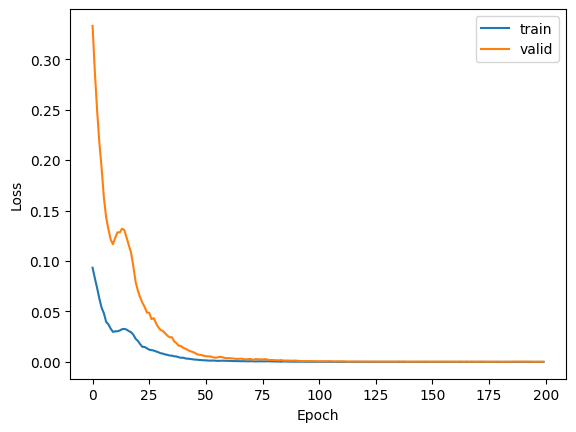

In [ ]:
plot_loss(log["train_loss"], log["valid_loss"])

In [ ]:
def get_preds(model, valid_dl):
    model.eval()

    X = []
    y_preds = []
    y_targs = []

    for xb, yb in valid_dl:
        with torch.inference_mode():
            out = model(xb)
        X.append(xb.view(len(xb), -1, 2)[:, :, 1])
        y_preds.append(out)
        y_targs.append(yb)

    X = torch.cat(X).numpy()
    y_preds = torch.cat(y_preds).numpy()
    y_targs = torch.cat(y_targs).numpy()

    return y_preds, y_targs, X

In [ ]:
y_preds, y_targs, X = get_preds(gmodel, g_valid_dl)

(120, 3200)